# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM transformed dataset

In [4]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig1c_fbm_scaled_gex_updated_dr_20200428.h5ad")

In [5]:
cell_numbers = adata.obs.groupby(["broad_fig1_cell.labels"]).apply(len)
cell_numbers

broad_fig1_cell.labels
HSC_MPP          7984
erythroid       26591
MK               2701
B_lineage       28613
DC               2460
eo/baso/mast     1112
neutrophil      10292
monocyte        16733
T_NK             1440
stroma           6726
dtype: int64

# Add metadata for slightly more detailed groupings

In [6]:
annot = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/fbm_broad_annots.csv")

In [7]:
refined_annot = annot["cell.labels"].tolist()
refined_annot

['Immature B cell',
 'Naive B cell',
 'Pre B progenitor',
 'Pre pro B progenitor',
 'Pro B progenitor',
 'DC precursor',
 'DC1',
 'DC2',
 'DC3',
 'pDC progenitor',
 'tDC',
 'basophil',
 'eosinophil',
 'mast cell',
 'early erythroid',
 'late erythroid',
 'mid erythroid',
 'CMP',
 'ELP',
 'eo/baso/mast precursor',
 'GMP',
 'HSC',
 'MEMP',
 'MEP',
 'MPP lymphoid',
 'MPP myeloid 1',
 'MPP myeloid 2',
 'myeloid DC progenitor',
 'neut myeloid',
 'pDC',
 'early MK',
 'MK',
 'CD14 monocyte',
 'monocyte precursor',
 'myelocyte',
 'neutrophil',
 'promyelocyte',
 'EI macrophage',
 'adipo-CAR',
 'arteriolar fibroblast',
 'chondrocyte',
 'early osteoblast',
 'endosteal fibroblast',
 'immature EC',
 'monocytoid macrophage',
 'muscle',
 'muscle stem cell',
 'myofibroblast',
 'osteoblast',
 'osteoblast precursor',
 'osteochondral precursor',
 'osteoclast',
 'proliferating EC',
 'schwann cells',
 'sinusoidal EC',
 'stromal macrophage',
 'tip EC',
 'CD4 T',
 'CD56 bright NK',
 'CD8 T',
 'ILC precursor',

In [8]:
broad_annot = annot["broad_detailed_figS1"].tolist()
broad_annot

['B_lineage',
 'B_lineage',
 'B_lineage',
 'B_lineage',
 'B_lineage',
 'DC_other',
 'DC1',
 'DC2',
 'DC_other',
 'HSC_MPP',
 'DC_other',
 'basophil',
 'eosinophil',
 'mast cell',
 'erythroid',
 'erythroid',
 'erythroid',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'HSC_MPP',
 'pDC',
 'MK',
 'MK',
 'CD14 monocyte',
 'monocyte precursor',
 'myelocyte',
 'neutrophil',
 'promyelocyte',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'T_NK',
 'T_NK',
 'T_NK',
 'T_NK',
 'T_NK',
 'T_NK',
 'T_NK']

In [9]:
adata.obs["broad_detailed_figS1"] = adata.obs["cell.labels"].replace(refined_annot, broad_annot)

In [10]:
adata.obs["broad_detailed_figS1"] = adata.obs["broad_detailed_figS1"].astype('category')
adata.obs["broad_detailed_figS1"].cat.categories

Index(['B_lineage', 'CD14 monocyte', 'DC1', 'DC2', 'DC_other', 'HSC_MPP', 'MK', 'T_NK', 'basophil', 'eosinophil', 'erythroid', 'mast cell', 'monocyte precursor', 'myelocyte', 'neutrophil', 'pDC', 'promyelocyte', 'stroma'], dtype='object')

# Run the dotplots

In [11]:
genes = ['PTPRC', 
'IL3RA',
'HLA-DRA',
'CD34',
'KIT',
'IL5RA',
'CD79A',
'CD14',
'MSR1',
'CLEC9A',
'CD1C',
'CD52',
'ITGAM',
'CEACAM8']

In [12]:
adata.obs["broad_fig1_cell.labels"] = adata.obs["broad_detailed_figS1"].cat.reorder_categories(['erythroid', 'MK', 
                'stroma', 'basophil', 'pDC', 'HSC_MPP', 'mast cell', 'eosinophil', 'B_lineage', 'CD14 monocyte', 
                'monocyte precursor', 'DC1', 'DC2', 'DC_other', 'T_NK', 'neutrophil', 'myelocyte', 'promyelocyte'])

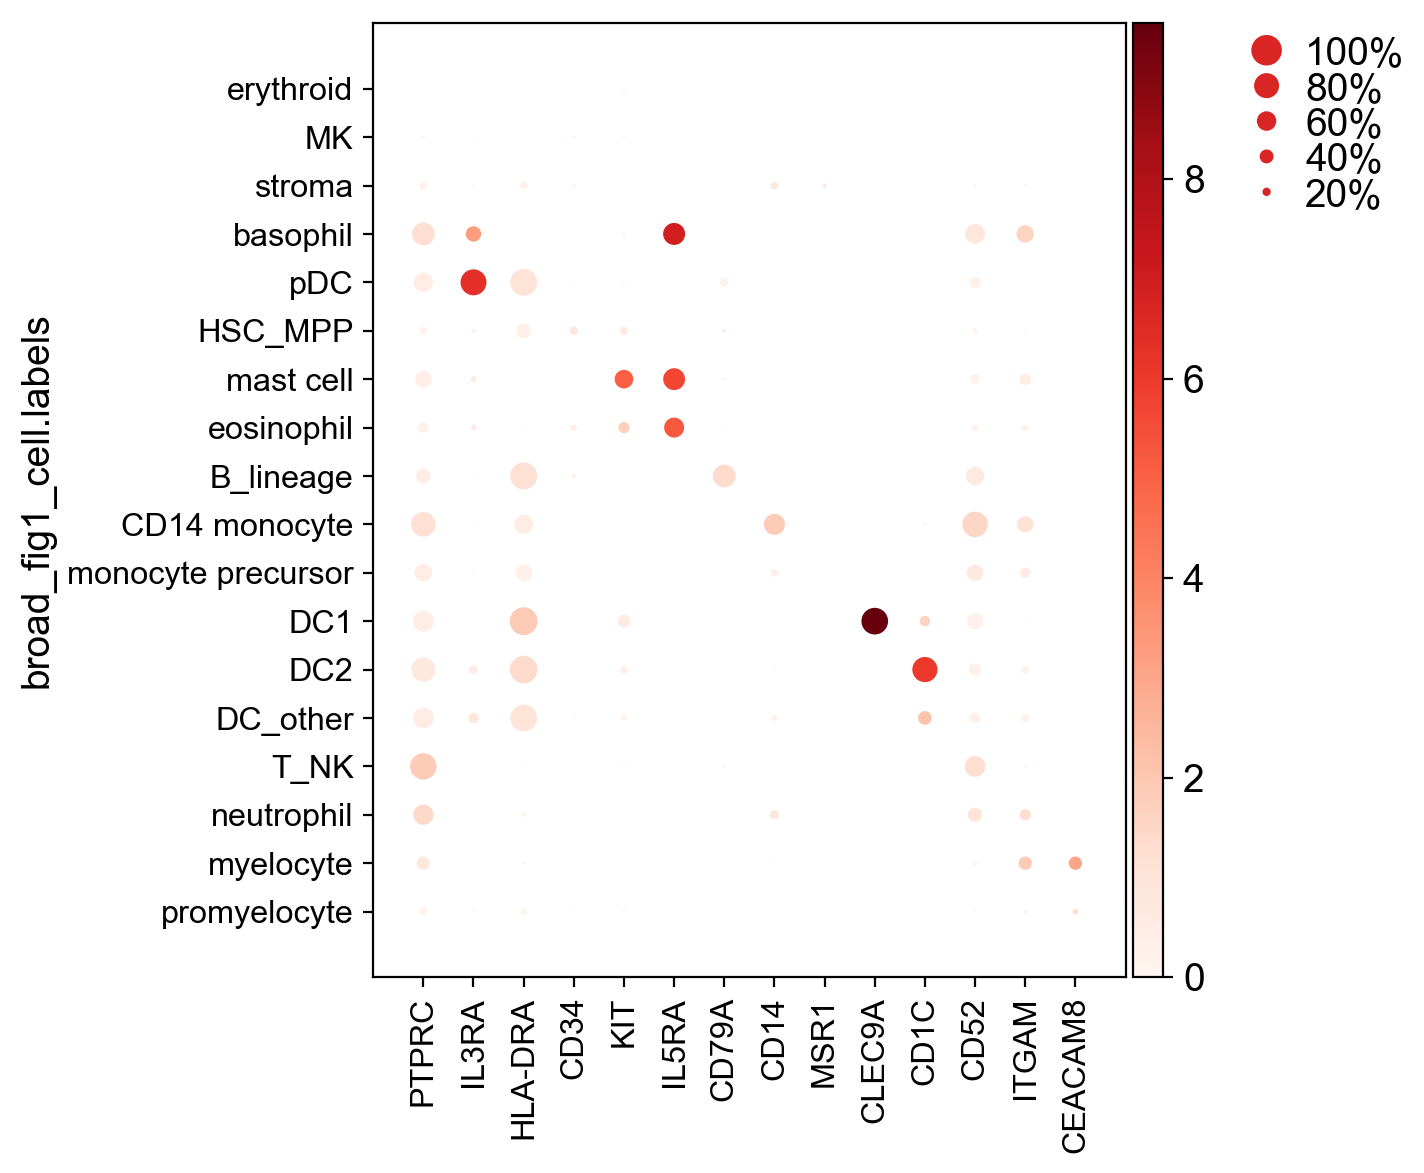

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.8999999999999995, 0, 0.2, 0.5, 0.25])

In [13]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.pl.dotplot(adata, var_names=genes, save="figs1d_overall_broad_dotplot_20200507.pdf", groupby="broad_fig1_cell.labels", use_raw=False)